# Analyze rRNA sequences and MAG sequences
- rRNA In viromes (10 g soil), but filtered, to keep viruses + broken DNA
- in total metaGs (0.25g soil), keep all organisms
- SortMeRNA was used to get the rRNA sequences
- RDPutils is used to get this data into plots


In [12]:
# load the needed libraries
library(RDPutils)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(vegan)
library(ape)
library(tidyr)
library(devtools)

In [3]:
# Open hier file, phyloseq object from SortMeRNA
hier.phy <- hier2phyloseq("../rrna/merged_hier.txt")


In [5]:
# Split the hier file into 2 phylosec objects, one for taxonomy and one as a otu table
otu <- as.data.frame(otu_table(hier.phy))
tax <- as.data.frame(tax_table(hier.phy))


In [25]:
# Write OTU table to file
write.csv(otu, '221003_OTU_16S.csv')

In [6]:
# rename the columns, so that they have the sample names as columns names
sample.names <- colnames(otu)

# clean the sample names
sample.names <- str_replace(sample.names, pattern = ".rrna.fq.gz", replacement = "")
#sample.names <- str_replace(sample.names, pattern = "\\_S.+?\\_L001", replacement = "")
sample.names <- str_replace_all(sample.names, pattern = "\\.", replacement = "_" )

# rename column names with the cleaned otu names
colnames(otu) <- sample.names
tax$OTU_ID <- row.names(tax)


In [7]:
# Hellinger transform the data
otu <- t(otu)
otu.xform <- decostand(otu, method="hellinger")


In [3]:
# create dissimilarity matrix for the vOTU table with bray method
otu.dist <- as.matrix(vegdist(otu.xform, method='bray'))

# nmds
otu.nmds <- metaMDS(otu.dist)
otu.nmds$stress


In [15]:
# load in metadata
cat_meta <- read.csv("../data/metadata.csv", sep=',', header=1, row.names=1)

# Order metadata
cat_meta.ordered <- cat_meta[match(row.names(otu.nmds$points), row.names(cat_meta)),]   

In [16]:
# perform pcoa with ape package pcoa
pcoa <- pcoa(as.dist(otu.dist))

# make a dataframe named axes, put pcoa values in there
axes <- as.data.frame(pcoa$vectors)

# Give df extra column with the rownames in it 
axes$SampleID <- rownames(axes)

# put the metadata in the same dataframe, with correct sample name
cat_meta.ordered$SampleID <- rownames(cat_meta.ordered)

cat_meta$SampleID <- rownames(cat_meta)


# calculate the eigenvalues for each pcoa axes 
eigval <- round(pcoa$values$Relative_eig * 100, digits = 2)

# merge those dfs
axes <- merge(cat_meta.ordered, axes, by.x = "SampleID", by.y = "SampleID")


In [18]:
# Put those eigenvalues in a df so they easy to get to. 
eigval <- data.frame( PC = 1:length(eigval), Eigval = eigval)
# head(eigval) # see top eigenvalues
eigval[[1,2]] # see first axes percentage
eigval[[2,2]] # second axes
eigval[[3,2]] # third axes
eigval[[4,2]] # fourth axes

[1] 37.06

[1] 12.69

[1] 10.05

[1] 5.78

In [2]:
# run permanova for continious data
pmanova2 = adonis(as.dist(otu.dist) ~  salinity + perc_moisture + timepoint + plot_detail + soil_ph + org_matter, data = cat_meta.ordered)
pmanova2

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



null device 
          1

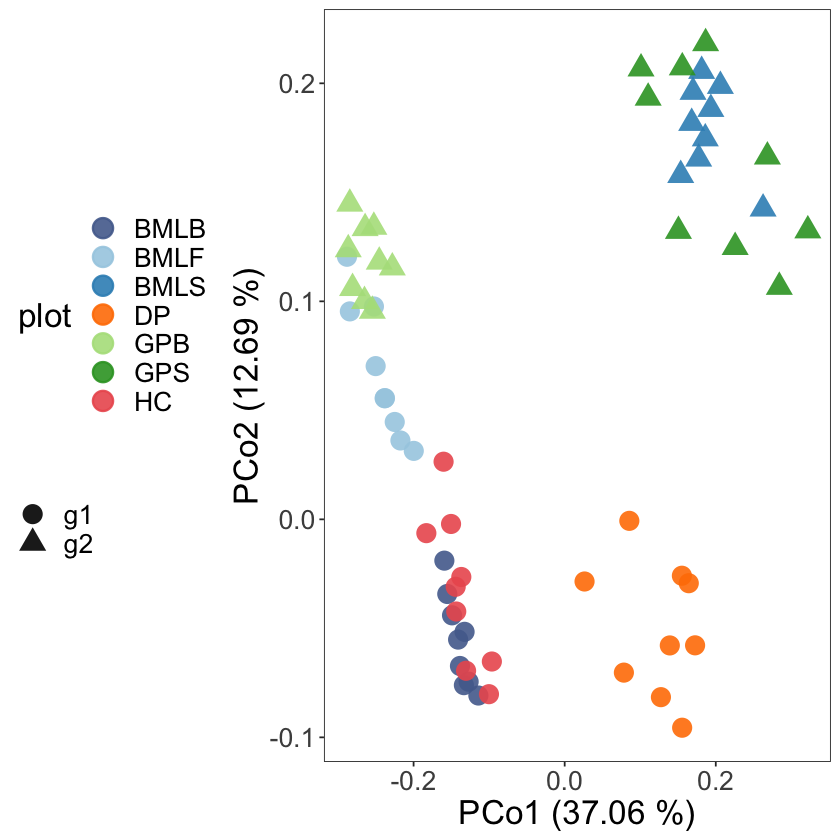

In [20]:
# Create PCoA of 16S rRNA OTU abundance table 

# write to pdf
#pdf("../plots/PCOA_bulk_16S.pdf")

# set plot
p <- ggplot(axes, aes(Axis.1, Axis.2), width = 7, height = 3) 

# set color of the points as the factor depth, shape as year, set size and see-throughness
p + geom_point(aes(colour=as.character(plot_detail), shape=as.character(veg_g)), size = 5,alpha=0.9, stroke=1) +
#p + geom_point(aes(colour=as.character(bulk_rhizo)), size = 6,alpha=0.9, stroke=1) +
 
  # set text for the axis lables
  xlab(paste("PCo1 (", eigval$Eigval[1], " %)", sep = "")) +  # or somthing else
  ylab(paste("PCo2 (", eigval$Eigval[2], " %)", sep = "")) +
  

  # dotted lines through the plot
  #geom_vline(xintercept = 0, linetype = 2) +
  #geom_hline(yintercept = 0, linetype = 2) +
  
  # set the colors of the points with the colorbrewer pallet
  scale_color_brewer(name = "", palette = "Paired") +
  scale_color_manual(name = 'plot', values = c("#536c9b", "#a6cee3", "#3690c0", "#ff7f00", "#b2df8a", '#33a02c', '#ec5c5dff'))  +

  # you can set colors manually by this: 
  #scale_color_manual(name = 'soil', values = c("#377eb8", "#e41a1c", "yellow")) +

  # set shapes of the points
  scale_shape_manual(name = "", values=c(16,17,15,18)) +

  # tell where the legend has to be
  guides(color = guide_legend(title.position = "left", title.hjust = 0.5)) +
  theme_bw() +
  
  # set text size for whole graph. set the background color (white with no lines)
  theme(text = element_text(size = 20), panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
        legend.position = "left") 
dev.off()

In [73]:
# Load viral OTU table to correlate with 16S and MAG data
votu <- read.table("../data/220810_covtab_norm.csv", 
              sep=",", header=T, row.names=1)

# transpose data
votu <- t(votu)

# remove rows with all zeros
votu <- votu[apply(votu[,-1], 1, function(x) !all(x==0)),]
                 
# transform the data
votu.xform <- decostand(votu, method="hellinger")

# create dissimilarity matrix for the vvOTU table with bray method
votu.dist <- as.matrix(vegdist(votu.xform, method='jaccard'))


In [76]:
# Perform correlation analysis between 16S OTU abundance data and vOTU abundance data
# They are sign correlated
# Same thing was done for MAG abundance data vs vOTU abund data (just not depicted here)
cor <- cor.test(votu.dist, otu.dist, method = "pearson", alternative = "two.sided")
cor


	Pearson's product-moment correlation

data:  votu.dist and otu.dist
t = 41.136, df = 3967, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5246338 0.5682650
sample estimates:
      cor 
0.5468206 


## MAG sequences
- Same thing, do PCoA analysis, correlate with vOTUs
- Code is the same as above, but still added here just in case someone wants to see it

In [4]:
# Load the files required and transpose
mag <- read.table("../MAGs/data/MAGs.csv", 
              sep=",", header=T, row.names=1)

# transpose data
mag <- t(mag)

# remove rows with all zeros
mag <- mag[apply(otu[,-1], 1, function(x) !all(x==0)),]
                 
# open metadata file
cat_meta <- read.csv("../MAGs/data/metadata.csv", sep=',', header=1, row.names=1)                 

In [10]:
# transform the data
mag.xform <- decostand(mag, method="hellinger")

# create dissimilarity matrix for the vmag table with bray method
mag.dist <- as.matrix(vegdist(mag.xform, method='bray'))

# nmds
mag.nmds <- metaMDS(mag.dist)
mag.nmds$stress

# R will not automatically bind datapoints with the same name, but randomly bind them
# therefore order cat data with this
cat_meta.ordered <- cat_meta[match(row.names(mag.nmds$points), row.names(cat_meta)),]   

# perform pcoa with ape package pcoa
pcoa <- pcoa(as.dist(mag.dist))

# make a dataframe named axes, put pcoa values in there
axes <- as.data.frame(pcoa$vectors)

# Give df extra column with the rownames in it 
axes$SampleID <- rownames(axes)

# put the metadata in the same dataframe, with correct sample name
cat_meta.ordered$SampleID <- rownames(cat_meta.ordered)

cat_meta$SampleID <- rownames(cat_meta)


# calculate the eigenvalues for each pcoa axes 
eigval <- round(pcoa$values$Relative_eig * 100, digits = 2)

# merge those dfs
axes <- merge(cat_meta.ordered, axes, by.x = "SampleID", by.y = "SampleID")


In [11]:
# permanova for MAGs vs various soil measurements (in this case only % soil moisture is depicted)
pmanova2 = adonis2(as.dist(mag.dist) ~ perc_moisture, data = cat_meta.ordered)
pmanova2

In [9]:
# Test correlation between viral community composition and MAG comm comp
# It's significant
cor <- cor.test(votu.dist, mag.dist, method = "pearson", alternative = "two.sided")
cor


	Pearson's product-moment correlation

data:  votu.dist and otu.dist
t = 70.325, df = 3967, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7307376 0.7584488
sample estimates:
      cor 
0.7449143 
